# imports and definitions of auxiliary functions

For $\mathbf N=(N^t)_{t\in\mathbb N}$ we set $f(\mathbf N):= \sum_{t\in\mathbb N}(N^t-N^{t+1})\mathbf 1\{N^t-N^{t+1}\geq 0\}$.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import accumulate
import random

def getPD1sample(n):
    remainder = n
    PD1 = []
    while remainder > 0:
        u = random.randint(1,remainder)
        PD1.append(u)
        remainder -= u
    return sorted(PD1)[::-1]

def f(N):
    ret = 0
    for i in range(len(N)-1):
        if N[i]>N[i+1]:
            ret += N[i]-N[i+1]
    return ret

print(getPD1sample(100))

[53, 27, 17, 2, 1]


# definition the main object

To simulate the Markov chain given by the discrete split-merge transition kernel $M_{n,g_s,g_m}$ (which is indeed close, as proved in the writeup, to its continuus analogue $M_{g_s,g_m}$) we need to create an instance of the ``discreteCoupling`` class defined below. This takes the following arguments:
 * $Y,Z\in \{(x_1,x_2,\dots):x_i\in\mathbb N,\sum_i x_i=n,x_1\geq x_2\geq\dots\}$. They are represented by a *list* in Python.
 * $n\in\mathbb N_+$; the level of granularity; should be thought of and chosen as $n\gg 1$.
 * $g_s,g_m\in[0,1]$; the probabilities of performing a split or merge, respectively.
 * $\varepsilon\in[0,1)$; the $\varepsilon$ as in Schramm's paper; for $n\gg 1$ we say an entry $X_i$ ($X\in\{Y,Z\}$) is *macroscopic* iff $X_i/n\geq \varepsilon$ and micro-/mesoscopic otherwise.
 
The following methods are currently implemented:
 * ``__init__()``: Called only when creating a new instance of this class.
 * ``updateInternalRepresentation()``: Only considers the attributes ``Y`` and ``Z`` (both of which need to be in non-increasing order and sum to $n$) and creates/updates the following attributes to fit ``Y`` and ``Z`` and the coupling defined in Schramm's paper:
   * ``Q``; the same as $Q^t$ in Schramm's paper, i.e. length of entries that are matched in $Y$ (or $Z$, doesn't matter).
   * ``N``; the number of unmatched entries.
   * ``Neps``; the same as $N^t$ in Schramm's paper, i.e. the number of unmatched entries that are bigger than $n\varepsilon$.
   * ``y1`` and ``z1``; the same as $y_1^t$ and $z_1^t$ in Schramm's paper, i.e. the largest unmatched entry in $Y$ and $Z$, respectively.
   * ``YC`` and ``ZC``; both are in $\{(x_1,x_2,\dots):x_i\in\mathbb N,\sum_i x_i=n\}$; the $i$-th component is the length of the $i$-th interval of what Schramm called $\tilde Y, \tilde Z$ in his definition of the coupling (pages 12-13).
 * ``evolve()``: Given $(Y^t,Z^t)=$ ``(Y,Z)``, this performs the transition to $\tilde M_{n,g_s,g_m}(Y^t,Z^t)=(Y^{t+1},Z^{t+1})$ with given $u,v,w$ ($u,v$ as in Schramm's paper, but multiplied by $n$ and rounded down to the next integer) and $w\in[0,1]$ to account for the possibility that a splitting/merging might not be performed with probability $g_s,g_m$ respectively.
 * ``__str__()``: Called only by methods that need a string representation of a given instance of this class, e.g. Python's ``print()``.

In [2]:
class discreteCoupling:
    
    def __init__(self, Y, Z, n=100, gs=1, gm=1, eps=1/100):
        self.n  = n
        self.gs = gs
        self.gm = gm
        self.lastOp = "CREATED" # for debugging only
        self.eps = eps # threshold; will say entries of 
        # size >eps*n are "macroscopic", the rest micro- or mesoscopic
        
        if isinstance(Y, list) and isinstance(Z, list):
            if sum(Y) == n and sum(Z) == n:
                if all(Yi > 0 for Yi in Y) and all(Zi > 0 for Zi in Z):
                    if all(Yi==int(Yi) for Yi in Y) and all(Zi==int(Zi) for Zi in Z):
                        if Y==sorted(Y)[::-1] and Z==sorted(Z)[::-1]:
                            self.Y = Y # Y in non-increasing order
                            self.Z = Z # Z in non-increasing order
                            self.updateInternalRepresentation()
                        else:
                            raise RuntimeError("Y or Z are not in non-increasing order!\n", Y,Z)
                    else:
                        raise RuntimeError("Y or Z do not consist of integers!\n", Y,Z)
                else:
                    raise RuntimeError("Y or Z do not consist of positive elements!\n", Y,Z)
            else:
                raise RuntimeError("Y or Z do not sum to n!\n", Y,Z)
        else:
            raise RuntimeError("Y or Z are not an array!\n", Y,Z)
    
    def updateInternalRepresentation(self):
        # make local copies we can modify without worrying about
        # the internal representation
        Y = self.Y.copy()
        Z = self.Z.copy()
        
        if not (Y==sorted(Y)[::-1] and Z==sorted(Z)[::-1]):
            raise RuntimeError("Y or Z are not in non-increasing order!\n", Y,Z)
                
        # sum of lengths of matched entries
        # (in Y; don't double count by also adding those from Z)
        self.Q = 0
        orderedEntries = []

        # for Y_i in Y check if there is a corresponding Z_i of 
        # the same length; if there is, remove them from the local
        # copies Y and Z -- the resulting Y,Z are going to be lists
        # holding all the unmatched entries in non-increasing order
        i=0
        while i<len(Y):
            Yi = Y[i]
            if Yi in Z:
                Z.remove(Yi)
                Y.remove(Yi)
                orderedEntries.append(Yi)
                self.Q += Yi
            else:
                i+=1
        # if all Y_i have been removed, this means that for each Y_i
        # there was a corresponding Z_i of the same length, hence
        # everything is matched
        if not Y:
            self.y1 = 0
            self.z1 = 0
        else:
            self.y1 = Y[0]
            self.z1 = Z[0]
        
        # number of unmatched entries
        self.N = len(Y)+len(Z)
        self.Neps = 0 # number of unmatched entries >1/100 (macroscopically)
        for y in Y:
            if y > self.n * self.eps: self.Neps += 1
        for z in Z:
            if z > self.n * self.eps: self.Neps += 1
        
        # add all the matched entries (in non-increasing order)
        Y.extend(orderedEntries)
        Z.extend(orderedEntries)

        # update/set internal variables with the locally computed ones
        self.YC = Y
        self.ZC = Z

    def evolve(self,u,v,w):
        #if not (u >= 0 and u < 1 and v >= 0 and v < 1 and w >= 0 and w <= 1):
        #    raise RuntimeError("u,v,w are not in [0,1]", u,v,w)
        
        YC = self.YC.copy()
        ZC = self.ZC.copy()
        
        YI = list(accumulate(YC)) # = np.cumsum(YC)
        ZI = list(accumulate(ZC))

        # find i such that u fell into the interval corresponding to YC[i]=:Yu 
        #  and j such that u fell into the interval corresponding to ZC[j]=:Zu
        for i in range(len(YI)):
            if u <= YI[i]:
                break
        for j in range(len(ZI)):
            if u <= ZI[j]:
                break
        
        Yu = YC[i] # length of the interval in YC that u fell into 
        Zu = ZC[j] # length of the interval in ZC that u fell into

        
        # create updated uYI which is the interval partition YI after shifting Yu to the left
        uYC = YC.copy() # make copy to modify
        uYC.pop(i) # delete Yu (the i-th entry)
        uYC.insert(0,Yu) # insert Yu in the first (0-th) place
        uYI = list(accumulate(uYC)) # create corresponding interval partition

        # create updated uZI which is the interval partition ZI after shifting Zu to the left
        uZC = ZC.copy() # make copy to modify
        uZC.pop(j) # delete Zu (the j-th entry)
        uZC.insert(0,Zu) # insert Zu in the first (0-th) place
        uZI = list(accumulate(uZC)) # create corresponding interval partition
        
        for i_ in range(len(uYI)):
            if v < uYI[i_]:
                if i_==0:
                    # SPLIT Yu into v,Yu w.p. self.gs
                    self.lastOp = "SPLIT with w="+str(w)
                    if w <= self.gs:
                        uYC.pop(0)
                        uYC.extend([Yu-v,v])
                else:
                    # MERGE Yu:=YC[i]=uYC[0] and Yv:=uYC[i_] w.p. self.gm
                    self.lastOp = "MERGE with w="+str(w)
                    if w <= self.gm:
                        Yv = uYC[i_]
                        uYC.pop(i_)
                        uYC.pop(0)
                        uYC.append(Yu+Yv)
                break
        for j_ in range(len(uZI)):
            if v < uZI[j_]:
                if j_==0:
                    # SPLIT Zu into v,Zu w.p. self.gs
                    if w <= self.gs:
                        uZC.pop(0)
                        uZC.extend([Zu-v,v])
                else:
                    # MERGE Zu:=ZC[j]=uZC[0] and Zv:=uZC[j_] w.p. self.gm
                    if w <= self.gm:
                        Zv = uZC[j_]
                        uZC.pop(j_)
                        uZC.pop(0)
                        uZC.append(Zu+Zv)
                break
        
        self.Y = sorted(uYC)[::-1]
        self.Z = sorted(uZC)[::-1]
        self.updateInternalRepresentation()
        
    def __str__(self):
        Ystring = "|"
        Zstring = "|"
        
        n = self.n
        YC = self.YC
        ZC = self.ZC
        Q = self.Q
        y1= self.y1
        z1= self.z1
        
        for y in self.YC:
            Ystring += "—"*(y-1)+"|"
        for z in self.ZC:
            Zstring += "—"*(z-1)+"|"
        
        Yinfo = "Y="+str([round(x,3) for x in YC])+"\n\t ->"+str([round(x,3) for x in list(accumulate(YC))])
        Zinfo = "Z="+str([round(x,3) for x in ZC])+"\n\t ->"+str([round(x,3) for x in list(accumulate(ZC))])
        
        if y1 < n - Q:
            topannotation = "0"+" "*(y1-2)+"y_1"+" "*(n-Q-y1-3)+"1-Q"+" "*(Q-2)+"1"
        else:
            topannotation = "0"+" "*(n-Q-4)+"y_1=1-Q"+" "*(Q-4)+"1"
        
        bottomannotation = " "*(z1-1)+"z_1"
        
        visualRepr = topannotation+"\n"+Ystring+"\n"+Zstring+"\n"+bottomannotation+"\n" if n<120 else ""
        
        return "="*105+"\n"+Yinfo+"\n"+Zinfo+"\n"+"N="+str(self.N)+"\n"+visualRepr+"="*105+"\n"*3

# showcase how to perform (and present) the Markov chain evolution with given initial data

In [3]:
n = 100
Y = [.5,.2,.15,.1,.05]
Z = [.5,.3,.1,.1]

YZ = discreteCoupling([int(Yi * n) for Yi in Y],[int(Zi * n) for Zi in Z],n,1,1)

print(YZ)

for i in range(3):
    u,v,w = random.randint(1,n),random.randint(1,n),random.random()
    print("u,v,w =",u/n,v/n,w)
    YZ.evolve(u,v,w)
    print(YZ.lastOp)
    print(YZ)
    print()

Y=[20, 15, 5, 50, 10]
	 ->[20, 35, 40, 90, 100]
Z=[30, 10, 50, 10]
	 ->[30, 40, 90, 100]
N=5
0                  y_1                 1-Q                                                          1
|———————————————————|——————————————|————|—————————————————————————————————————————————————|—————————|
|—————————————————————————————|—————————|—————————————————————————————————————————————————|—————————|
                             z_1



u,v,w = 0.31 0.99 0.3057777015687605
MERGE with w=0.3057777015687605
Y=[25, 5, 50, 20]
	 ->[25, 30, 80, 100]
Z=[30, 50, 20]
	 ->[30, 80, 100]
N=3
0                       y_1  1-Q                                                                    1
|————————————————————————|————|—————————————————————————————————————————————————|———————————————————|
|—————————————————————————————|—————————————————————————————————————————————————|———————————————————|
                             z_1




u,v,w = 0.95 0.22 0.1547546114203402
MERGE with w=0.1547546114203402
Y=[45, 

# plot $\mathbf N=(N^t)_{t=0}^{\inf\{\tau:N^\tau=0\}}$ for $\theta = 2$

N[0] = 11 | f(N) = 30 | len(N) = 2823


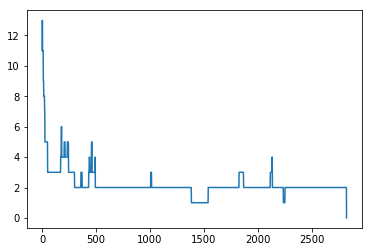

In [4]:
n = 1000000


def displayNTillNisZero(n):
    Y = getPD1sample(n)
    Z = getPD1sample(n)

    YZ = discreteCoupling(Y,Z,n,1,.5) # g_s=1, g_m=.5 ==> theta=2
    N = [YZ.Neps,]
    #YZlist = [YZ,]
    #counter = 0
    while N[-1] > 0:#N[0]/2:
    #    if counter % 100 == 0:
    #        print(N[-1])
    #        print("max(YZ.y1,YZ.z1) =",max(YZ.y1,YZ.z1))
    #        print("Q =",YZ.Q)
        u,v,w = random.randint(1,n),random.randint(1,n),random.random()
        YZ.evolve(u,v,w)
        N.append(YZ.Neps)
        #YZlist.append(YZ)
    print("N[0] =",N[0],"| f(N) =",f(N), "| len(N) =",len(N))
    plt.plot(N)
    
displayNTillNisZero(n)

# get some statistics like $\mathbb E \inf\{\tau:N^\tau=0\}$ and $f(\mathbf N)$
Should condition on $\{N^0=C\}$ and find out the "worst" initial distribution $(Y^0,Z^0)$ to start with for any given $N^0$ (i.e. the one that maximises $f\big((N^t)_{t=0}^{\inf\{\tau:N^\tau=0\}}\big)$ in expectation).

In [5]:
def getNStats(n):
    Y = getPD1sample(n)
    Z = getPD1sample(n)
    YZ = discreteCoupling(Y,Z,n,1,.5)
    N = [YZ.Neps,]
    while N[-1] > 0:#N[0]/2:
        u,v,w = random.randint(1,n),random.randint(1,n),random.random()
        YZ.evolve(u,v,w)
        N.append(YZ.Neps)
    return (N[0],f(N),len(N))

res = []
tries = 100
for i in range(5,8):
    n = 10**i
    avgN0,avgfN,avgLenN = 0,0,0
    for m in range(tries):
        data = getNStats(n)
        avgN0 += data[0]/tries
        avgfN += data[1]/tries
        avgLenN += data[2]/tries
    res.append([avgN0,avgfN,avgLenN])

print(res)

[[9.35, 22.089999999999993, 1077.3100000000004], [9.14, 21.820000000000004, 1122.8700000000001], [9.120000000000003, 21.200000000000003, 940.5299999999995]]


# inherit all the attributes and methods from the ``discreteCoupling`` class, but rewrite the ``evolve()`` method to be conditioned on $\mathcal A_{t+1}$ as defined in Schramm's paper
Not finished yet! For some reason it doesn't work for $\theta > 1$.

In [6]:
class discreteCouplingEps(discreteCoupling):
    def evolve(self):
        #if not (u >= 0 and u < 1 and v >= 0 and v < 1 and w >= 0 and w <= 1):
        #    raise RuntimeError("u,v,w are not in [0,1]", u,v,w)
        
        YC = self.YC.copy()
        ZC = self.ZC.copy()
        
        eps = self.eps
        n   = self.n
        
        w   = random.random()
        
        YI = list(accumulate(YC)) # = np.cumsum(YC)
        ZI = list(accumulate(ZC))

        Yu,Zu = 0,0
        # choose u uniformly at random until it hits Yu, Zu that are both >eps*n
        while min(Yu,Zu) < eps*n:
            u = random.randint(1,n)
            # find i such that u fell into the interval corresponding to YC[i]=:Yu 
            #  and j such that u fell into the interval corresponding to ZC[j]=:Zu
            for i in range(len(YI)):
                if u <= YI[i]:
                    break
            for j in range(len(ZI)):
                if u <= ZI[j]:
                    break

            Yu = YC[i] # length of the interval in YC that u fell into 
            Zu = ZC[j] # length of the interval in ZC that u fell into
        
        # create updated uYI which is the interval partition YI after shifting Yu to the left
        uYC = YC.copy() # make copy to modify
        uYC.pop(i) # delete Yu (the i-th entry)
        uYC.insert(0,Yu) # insert Yu in the first (0-th) place
        uYI = list(accumulate(uYC)) # create corresponding interval partition

        # create updated uZI which is the interval partition ZI after shifting Zu to the left
        uZC = ZC.copy() # make copy to modify
        uZC.pop(j) # delete Zu (the j-th entry)
        uZC.insert(0,Zu) # insert Zu in the first (0-th) place
        uZI = list(accumulate(uZC)) # create corresponding interval partition
        
        minY,minZ = 0,0
        
        
        
        #vCandidates = range(int(eps*n)+1,n)
        #vCandidates = [v for v in vCandidates if v in range(Yu-int(n*eps)-1,Yu)]
        #for i in range(len(YI)):
         #   vCandidates = [v for v in vCandidates if v in range(Yu-int(n*eps)-1,Yu)]
        
        while min(minY,minZ) < eps*n:
            v = random.randint(int(eps*n)+1,n)
            for i_ in range(len(uYI)):
                if v < uYI[i_]:
                    if i_==0:
                        # SPLIT Yu into v,Yu w.p. self.gs
                        self.lastOp = "SPLIT with w="+str(w)
                        if w <= self.gs:
                            minY = Yu-v # v is already >eps*n by construction, so only need to check Yu-v
                            Yaction = "SPLIT"
                    else:
                        # MERGE Yu:=YC[i]=uYC[0] and Yv:=uYC[i_] w.p. self.gm
                        self.lastOp = "MERGE with w="+str(w)
                        if w <= self.gm:
                            Yv = uYC[i_]
                            minY = Yv # Yu is already >eps*n by construction, so only need to check Yv
                            Yaction = "MERGE"
                    break
            for j_ in range(len(uZI)):
                if v < uZI[j_]:
                    if j_==0:
                        # SPLIT Zu into v,Zu w.p. self.gs
                        if w <= self.gs:
                            minZ = Zu-v
                            Zaction = "SPLIT"
                    else:
                        # MERGE Zu:=ZC[j]=uZC[0] and Zv:=uZC[j_] w.p. self.gm
                        if w <= self.gm:
                            Zv = uZC[j_]
                            minZ = Zv
                            Zaction = "MERGE"
                    break
        
        if Yaction == "SPLIT":
            uYC.pop(0)
            uYC.extend([Yu-v,v])
        elif Yaction == "MERGE":
            uYC.pop(i_)
            uYC.pop(0)
            uYC.append(Yu+Yv)
        
        if Zaction == "SPLIT":
            uZC.pop(0)
            uZC.extend([Zu-v,v])
        elif Zaction == "MERGE":
            uZC.pop(j_)
            uZC.pop(0)
            uZC.append(Zu+Zv)
        

        self.Y = sorted(uYC)[::-1]
        self.Z = sorted(uZC)[::-1]
        self.updateInternalRepresentation()

# more simulations

N[0] = 14 | f(N) = 12 | len(N) = 167


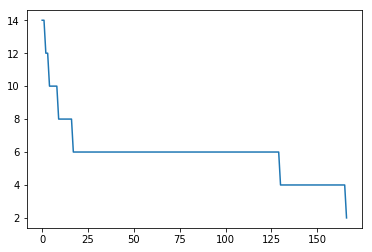

In [7]:
Y = getPD1sample(n)
Z = getPD1sample(n)

YZ = discreteCouplingEps(Y,Z,n,1,1)
N = [YZ.Neps,]
#YZlist = [YZ,]
while N[-1] > 3:
#for i in range(20000):
    YZ.evolve()
    N.append(YZ.Neps)

print("N[0] =",N[0],"| f(N) =",f(N), "| len(N) =",len(N))
plt.plot(N)